In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy

from itertools import combinations

from tqdm import tqdm

np.random.seed(42)

In [2]:
def check_reaction_3(molecule1, molecule2):  
    """
    This functions checks whether the reaction of the 3rd type between 2 given molecules makes sense.
    For example:
    check_reaction_3("A", "B") = False, since A + B -> AB is a reaction of a first type
    check_reaction_3("A", "AB") = False, since A + AB -> AB + A is a trivial reaction
    check_reaction_3("A", "BC") = True, since A + BC -> ABC is a normal reaction of third type
    check_reaction_3("AB", "BC") = True, since AB + BC -> ABC + B is a normal reaction of third type
    """
    
    if len(molecule1) == 1 and len(molecule2) == 1:
        return False
    
    if molecule1 in molecule2 or molecule2 in molecule1:
        return False
    
    return True  


All three parts can (and should!) be run separately. I just combined them into one notebook for better readability.

# a. Original simulation

In [2]:
N = 3  # Number of elements
num_generations = 1000
num_creatures = 10
max_creatures = 20
mutation_rate = 0.01

elements = ['A', 'B', 'C']
assert len(elements) == N


molecules = [''.join(combo) for r in range(1, len(elements) + 1) for combo in combinations(elements, r)]
concentrations = {m: 0.5 for m in molecules} # Uniform concentrations in the beginning

print(f"The (2^{N}-1)={2**N - 1} molecules are: {molecules}")

The (2^3-1)=7 molecules are: ['A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC']


In [4]:
SCALING_FACTOR = 100 # number by which we multiply benefits and toxicity to add to our population
REACTION_STRENGTH = 0.01 # number by which concentrations of molecules increase/decrease in every reaction

class Creature:
    def __init__(self, id_num, population = 1000, first_generation = 0, father=None):
        self.id = id_num
        self.population = population
        self.first_generation = first_generation  # Saving when the creature was created, to correctly plot it afterward
                
        if father is not None:
            self.coefficients = copy.deepcopy(father.coefficients)
            self.toxicity = copy.deepcopy(father.toxicity)
            
            # Random mutation: 
            molecule = np.random.choice(molecules)
            
            if np.random.uniform() < 1.0/4:
                self.toxicity[molecule] *= np.random.uniform(0.5, 1.5)
            else:
                i = np.random.randint(0, 2 + 1)
                j = np.random.randint(0, 1 + 1)
                
                if i != 2: # Not third reaction
                    while len(molecule) == 1:  # First and second reactions could not happen with molecule of one letter
                        molecule = np.random.choice(molecules)
                    self.coefficients[i][j][molecule] *= np.random.uniform(0.5, 1.5)
                    
                else:
                    molecule2 = np.random.choice(molecules)
                    while not check_reaction_3(molecule, molecule2):
                        molecule2 = np.random.choice(molecules)
                    self.coefficients[i][j][molecule][molecule2] *= np.random.uniform(0.5, 1.5)
                    
            return
        
        # Initializing coefficients
        
        self.toxicity = {m: np.random.uniform() for m in molecules}  # Toxicity of every molecule
        
        # First type of reactions, cannot happen for 1 letter molecules
        reaction_1_likelihood = {m: np.random.uniform() for m in molecules if len(m) > 1}
        reaction_1_benefit = {m: np.random.uniform(-1, 1) for m in molecules if len(m) > 1} # Benefit / penalty
        
        # Second type of reactions, cannot happen for 1 letter molecules
        reaction_2_likelihood = {m: np.random.uniform() for m in molecules}
        reaction_2_benefit = {m: np.random.uniform(-1, 1) for m in molecules} # Benefit / penalty
        
        # Third type of reactions
        reaction_3_likelihood = {}
        reaction_3_benefit = {}
        # So we can access likelihood of the reaction A + BC -> ABC as reaction_3_likelihood["A"]["BC"] 
        # The component first in the molecules list should always go first, trying to access reaction_3_likelihood["BC"]["A"] will result in error
        
        for m1 in molecules:
            reaction_3_likelihood[m1] = {}
            reaction_3_benefit[m1] = {}
            
            for m2 in molecules:
                if check_reaction_3(m1, m2):
                    reaction_3_likelihood[m1][m2] = np.random.uniform()
                    reaction_3_benefit[m1][m2] = np.random.uniform(-1, 1)
                
        self.coefficients = [[reaction_1_likelihood, reaction_1_benefit], 
                             [reaction_2_likelihood, reaction_2_benefit], 
                             [reaction_3_likelihood, reaction_3_benefit]] # List of all coefficients 


    def __lt__(self, other):  # For sorting
        return self.population < other.population


    def reaction_1(self, molecule):
        reaction_chance = self.coefficients[0][0][molecule] * concentrations[molecule]
        
        if np.random.uniform() < reaction_chance:
            for element in molecule:
                concentrations[element] -= REACTION_STRENGTH
                
            concentrations[molecule] += REACTION_STRENGTH
            
            self.population += int(self.coefficients[0][1][molecule] * SCALING_FACTOR) 
            self.population -= int(self.toxicity[molecule] * REACTION_STRENGTH * SCALING_FACTOR)
            
            
    def reaction_2(self, molecule):
        reaction_chance = self.coefficients[1][0][molecule] * concentrations[molecule]
        
        if np.random.uniform() < reaction_chance:
            for element in molecule:
                concentrations[element] += REACTION_STRENGTH
                self.population -= int(self.toxicity[element] * REACTION_STRENGTH * SCALING_FACTOR)

                
            concentrations[molecule] -= REACTION_STRENGTH
            
            self.population += int(self.coefficients[1][1][molecule] * SCALING_FACTOR) 
            
            
    def reaction_3(self, m1, m2):
        reaction_chance = self.coefficients[2][0][m1][m2] * concentrations[m1] * concentrations[m2]
        
        if np.random.uniform() < reaction_chance:
            merged = ''.join(sorted(set(m1 + m2)))
            leftovers = ''.join(sorted(set(m1) & set(m2)))
            
            concentrations[m1] -= REACTION_STRENGTH
            concentrations[m2] -= REACTION_STRENGTH
            
            concentrations[merged] += REACTION_STRENGTH
            
            self.population += int(self.coefficients[2][1][m1][m2] * SCALING_FACTOR)
            self.population -= int(self.toxicity[merged] * REACTION_STRENGTH * SCALING_FACTOR)
            
            if leftovers != "":
                concentrations[leftovers] += REACTION_STRENGTH
                self.population -= int(self.toxicity[leftovers] * REACTION_STRENGTH * SCALING_FACTOR)
        

    def perform_reactions(self):  # Main function to perform all reactions on every step
        
        for molecule in molecules:
            if len(molecule) > 1:
                self.reaction_1(molecule)
                self.reaction_2(molecule)
            
            for molecule2 in molecules:
                if check_reaction_3(molecule, molecule2):
                    self.reaction_3(molecule, molecule2)
            

In [5]:
# Main logic
creatures = [Creature(id_num=i) for i in range(num_creatures)]  # Creatures with increasing ids
current_id = len(creatures)

populations = {}
first_generations = {creature.id: 0 for creature in creatures}

# Simulation loop
for generation in tqdm(range(num_generations)):
    # Each creature performs its reactions
    for creature in creatures:
        creature.perform_reactions()

        # Mutation
        if np.random.uniform() < mutation_rate:
            mutated_population = int(creature.population * 0.01)
            creatures.append(Creature(id_num=current_id, population=mutated_population, first_generation=generation, father=creature))
            
            creature.population -= mutated_population
            
            first_generations[current_id] = generation
            
            current_id += 1
        
    # Remove creatures close to extinction
    creatures = [creature for creature in creatures if creature.population > 1]
    
    if len(creatures) > max_creatures:
        creatures = sorted(creatures)
        creatures = creatures[-max_creatures:]
    
    if generation % 1 == 0:  # Collecting data every generation, can be changed
        for creature in creatures:
            if creature.id in populations.keys():
                populations[creature.id].append(creature.population)
            else:
                populations[creature.id] = [creature.population]
                
        if generation % 100 == 0:
            print(f"Generation {generation}: Total Population: {sum([creature.population for creature in creatures])}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Generation 0: Total Population: 9771
Generation 100: Total Population: 29710


 23%|██▎       | 226/1000 [00:00<00:00, 2246.63it/s]

Generation 200: Total Population: 33518
Generation 300: Total Population: 33155
Generation 400: Total Population: 32940


 45%|████▌     | 451/1000 [00:00<00:00, 1799.79it/s]

Generation 500: Total Population: 32423


 64%|██████▎   | 637/1000 [00:00<00:00, 1716.77it/s]

Generation 600: Total Population: 32195
Generation 700: Total Population: 32042


 81%|████████  | 812/1000 [00:00<00:00, 1668.26it/s]

Generation 800: Total Population: 31727


100%|██████████| 1000/1000 [00:00<00:00, 1696.73it/s]

Generation 900: Total Population: 31348


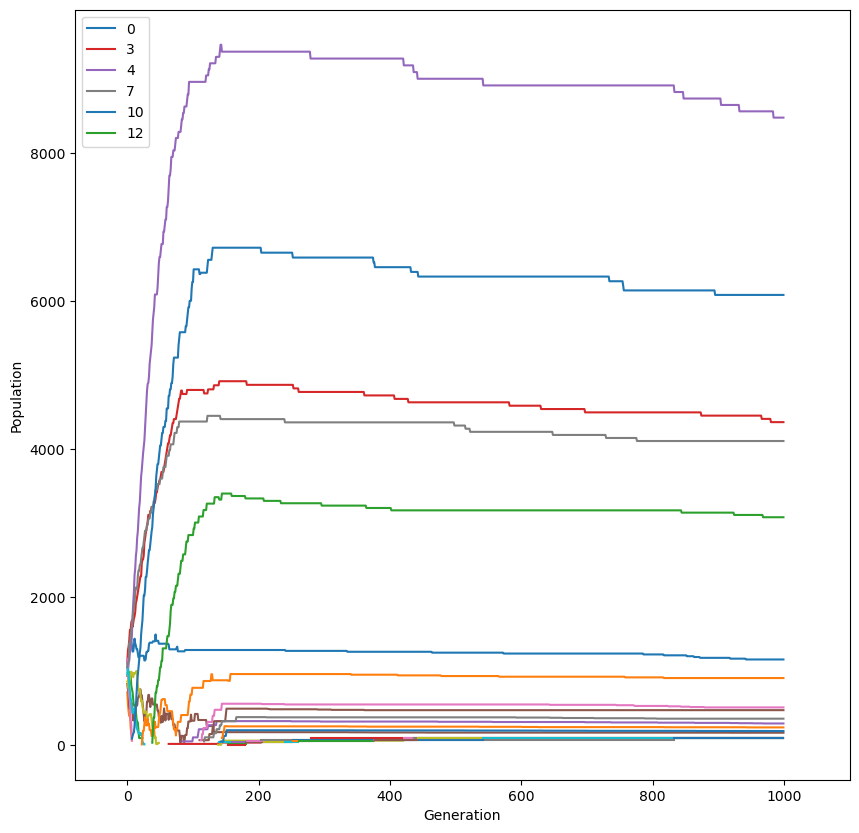

In [12]:
plt.figure(figsize=(10, 10))
for key, val in populations.items():
    
    label = key if len(val) > 10 and val[-1] > 1000 else "_nolegend_"
    
    plt.plot([t for t in range(first_generations[key], len(val) + first_generations[key])], val, label=label)
    
    
plt.xlabel('Generation')
plt.ylabel('Population')
plt.xlim((-80, 1100))
plt.legend()


Okay, this is a graph after 1000 generation. Let's discuss it a bit. We can see that after initial rise in population all "lucky" species are stabilised around some population and then started decreasing in population a bit. 

Even though the cap for number of species is 20, only 6 species ended up with population >1000 (bigger than they started).

We can see that in our model bigger species cannot go extinct very fast, since we are adding (subtraction) factors, not multiplying them. So on this big graph we cannot see any sudden extreme extinction events. 

Interesting fact here is that green species (id = 12) is not part of the original 10. So, there was a very good mutation, which allowed this species to climb up to 5th place. 

Let's now see the bottom part of the graph in more detail:

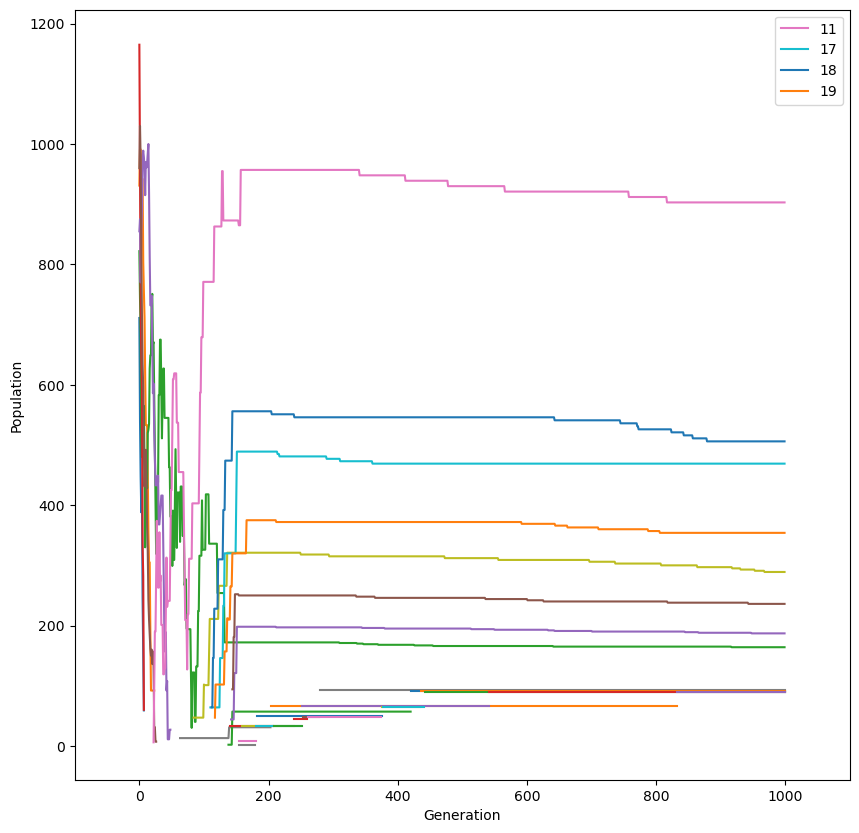

In [16]:
plt.figure(figsize=(10, 10))
for key, val in populations.items():
    if val[-1] > 1000:
        continue
    label = key if len(val) > 10 and val[-1] > 300 else "_nolegend_"
    plt.plot([t for t in range(first_generations[key], len(val) + first_generations[key])], val, label=label)
    
    
plt.xlabel('Generation')
plt.ylabel('Population')
plt.xlim((-100, 1100))
plt.legend()

Here we can see that early on some pretty big species have died suddenly, perhaps because they were toxic to particular molecules, which started to dominate. We can see that stability is reached for most species, even if it is around pretty small population. There are again no big extinctions after the system stabilized, some of the abrupt "extinctions" are due to the cap on the allowed number of species.

There are a lot more ways how we can play with this simulation. It is working pretty good and it's nice. But for now I will stop here, because I need to do more tasks :)

One small note: it was very motivating to put together this simple simulation and watch it achieve stability and recreate some natural processes, thanks for the task :)

# b. 2d grid

Okay, now we want to add a 2d grid, and allow migration to the neighbouring locations. I don't quite understand what other features we want exactly, so I will have different concentrations for each cell in the grid. Every generation there will be a small chance for species to migrate to the random neighbouring cell.

In [8]:
N = 3  # Number of elements
num_generations = 1000
num_creatures = 10
max_creatures = 20
mutation_rate = 0.01

elements = ['A', 'B', 'C']
assert len(elements) == N


molecules = [''.join(combo) for r in range(1, len(elements) + 1) for combo in combinations(elements, r)]

print(f"The (2^{N}-1)={2**N - 1} molecules are: {molecules}")

grid_size = 3  # 3x3 grid
migration_rate = 0.05  # Probability of migrating to a neighboring cell

concentrations = [[{m: 0.5 for m in molecules} for _ in range(grid_size)] for _ in range(grid_size)] # Uniform concentrations in the beginning, same for each cell

The (2^3-1)=7 molecules are: ['A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC']


In [9]:
SCALING_FACTOR = 100 # number by which we multiply benefits and toxicity to add to our population
REACTION_STRENGTH = 0.01 # number by which concentrations of molecules increase/decrease in every reaction

class Creature:
    def __init__(self, id_num, x, y, population = 1000, first_generation = 0, father=None):
        self.id = id_num
        self.x = x
        self.y = y
        self.population = population
        self.first_generation = first_generation  # Saving when the creature was created, to correctly plot it afterward
                
        if father is not None:
            self.coefficients = copy.deepcopy(father.coefficients)
            self.toxicity = copy.deepcopy(father.toxicity)
            
            # Random mutation: 
            molecule = np.random.choice(molecules)
            
            if np.random.uniform() < 1.0/4:
                self.toxicity[molecule] *= np.random.uniform(0.5, 1.5)
            else:
                i = np.random.randint(0, 2 + 1)
                j = np.random.randint(0, 1 + 1)
                
                if i != 2: # Not third reaction
                    while len(molecule) == 1:  # First and second reactions could not happen with molecule of one letter
                        molecule = np.random.choice(molecules)
                    self.coefficients[i][j][molecule] *= np.random.uniform(0.5, 1.5)
                    
                else:
                    molecule2 = np.random.choice(molecules)
                    while not check_reaction_3(molecule, molecule2):
                        molecule2 = np.random.choice(molecules)
                    self.coefficients[i][j][molecule][molecule2] *= np.random.uniform(0.5, 1.5)
                    
            return
        
        # Initializing coefficients
        
        self.toxicity = {m: np.random.uniform() for m in molecules}  # Toxicity of every molecule
        
        # First type of reactions, cannot happen for 1 letter molecules
        reaction_1_likelihood = {m: np.random.uniform() for m in molecules if len(m) > 1}
        reaction_1_benefit = {m: np.random.uniform(-1, 1) for m in molecules if len(m) > 1} # Benefit / penalty
        
        # Second type of reactions, cannot happen for 1 letter molecules
        reaction_2_likelihood = {m: np.random.uniform() for m in molecules}
        reaction_2_benefit = {m: np.random.uniform(-1, 1) for m in molecules} # Benefit / penalty
        
        # Third type of reactions
        reaction_3_likelihood = {}
        reaction_3_benefit = {}
        # So we can access likelihood of the reaction A + BC -> ABC as reaction_3_likelihood["A"]["BC"] 
        # The component first in the molecules list should always go first, trying to access reaction_3_likelihood["BC"]["A"] will result in error
        
        for m1 in molecules:
            reaction_3_likelihood[m1] = {}
            reaction_3_benefit[m1] = {}
            
            for m2 in molecules:
                if check_reaction_3(m1, m2):
                    reaction_3_likelihood[m1][m2] = np.random.uniform()
                    reaction_3_benefit[m1][m2] = np.random.uniform(-1, 1)
                
        self.coefficients = [[reaction_1_likelihood, reaction_1_benefit], 
                             [reaction_2_likelihood, reaction_2_benefit], 
                             [reaction_3_likelihood, reaction_3_benefit]] # List of all coefficients 


    def __lt__(self, other):  # For sorting
        return self.population < other.population

    def move(self):
        if np.random.uniform() < migration_rate:
            self.x = (self.x + np.random.choice([-1, 0, 1])) % grid_size
            self.y = (self.y + np.random.choice([-1, 0, 1])) % grid_size

    def reaction_1(self, molecule):
        reaction_chance = self.coefficients[0][0][molecule] * concentrations[self.x][self.y][molecule]
        
        if np.random.uniform() < reaction_chance:
            for element in molecule:
                concentrations[self.x][self.y][element] -= REACTION_STRENGTH
                
            concentrations[self.x][self.y][molecule] += REACTION_STRENGTH
            
            self.population += int(self.coefficients[0][1][molecule] * SCALING_FACTOR) 
            self.population -= int(self.toxicity[molecule] * REACTION_STRENGTH * SCALING_FACTOR)
            
            
    def reaction_2(self, molecule):
        reaction_chance = self.coefficients[1][0][molecule] * concentrations[self.x][self.y][molecule]
        
        if np.random.uniform() < reaction_chance:
            for element in molecule:
                concentrations[self.x][self.y][element] += REACTION_STRENGTH
                self.population -= int(self.toxicity[element] * REACTION_STRENGTH * SCALING_FACTOR)

                
            concentrations[self.x][self.y][molecule] -= REACTION_STRENGTH
            
            self.population += int(self.coefficients[1][1][molecule] * SCALING_FACTOR) 
            
            
    def reaction_3(self, m1, m2):
        reaction_chance = self.coefficients[2][0][m1][m2] * concentrations[self.x][self.y][m1] * concentrations[self.x][self.y][m2]
        
        if np.random.uniform() < reaction_chance:
            merged = ''.join(sorted(set(m1 + m2)))
            leftovers = ''.join(sorted(set(m1) & set(m2)))
            
            concentrations[self.x][self.y][m1] -= REACTION_STRENGTH
            concentrations[self.x][self.y][m2] -= REACTION_STRENGTH
            
            concentrations[self.x][self.y][merged] += REACTION_STRENGTH
            
            self.population += int(self.coefficients[2][1][m1][m2] * SCALING_FACTOR)
            self.population -= int(self.toxicity[merged] * REACTION_STRENGTH * SCALING_FACTOR)
            
            if leftovers != "":
                concentrations[self.x][self.y][leftovers] += REACTION_STRENGTH
                self.population -= int(self.toxicity[leftovers] * REACTION_STRENGTH * SCALING_FACTOR)
        

    def perform_reactions(self):  # Main function to perform all reactions on every step
        
        for molecule in molecules:
            if len(molecule) > 1:
                self.reaction_1(molecule)
                self.reaction_2(molecule)
            
            for molecule2 in molecules:
                if check_reaction_3(molecule, molecule2):
                    self.reaction_3(molecule, molecule2)
            

In [10]:
# Main logic
creatures = [Creature(id_num=i, x=np.random.randint(grid_size), y=np.random.randint(grid_size)) for i in range(num_creatures)]  # Creatures with increasing ids
current_id = len(creatures)

populations = {}
first_generations = {creature.id: 0 for creature in creatures}

# Simulation loop
for generation in tqdm(range(num_generations)):
    # Each creature performs its reactions
    
    for creature in creatures:
        creature.perform_reactions()
        creature.move()

        # Mutation
        if np.random.uniform() < mutation_rate:
            mutated_population = int(creature.population * 0.01)
            creatures.append(Creature(id_num=current_id, x=creature.x, y=creature.y, population=mutated_population, 
                                      first_generation=generation, father=creature))
            
            creature.population -= mutated_population
            
            first_generations[current_id] = generation
            
            current_id += 1
        
    # Remove creatures close to extinction
    creatures = [creature for creature in creatures if creature.population > 1]
    
    if len(creatures) > max_creatures:
        creatures = sorted(creatures)
        creatures = creatures[-max_creatures:]
    
    if generation % 1 == 0:  # Collecting data every generation, can be changed
        for creature in creatures:
            if creature.id in populations.keys():
                populations[creature.id].append(creature.population)
            else:
                populations[creature.id] = [creature.population]
                
        if generation % 100 == 0:
            print(f"Generation {generation}: Total Population: {sum([creature.population for creature in creatures])}")

 49%|████▉     | 493/1000 [00:00<00:00, 1691.52it/s]

Generation 0: Total Population: 9609
Generation 100: Total Population: 30698
Generation 200: Total Population: 94924
Generation 300: Total Population: 280740
Generation 400: Total Population: 537059


 84%|████████▍ | 838/1000 [00:00<00:00, 1442.41it/s]

Generation 500: Total Population: 792856
Generation 600: Total Population: 1041641
Generation 700: Total Population: 1312740
Generation 800: Total Population: 1609085
Generation 900: Total Population: 1895192


100%|██████████| 1000/1000 [00:00<00:00, 1504.92it/s]


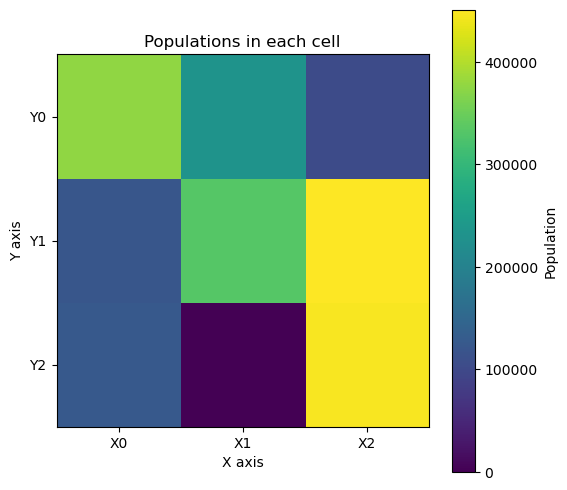

In [14]:
grid_populations = [[sum([creature.population for creature in creatures if creature.x == x and creature.y == y]) 
                     for y in range(grid_size)] for x in range(grid_size)]  # I know, I am enjoying list comprehensions way too much, sorry :)

plt.figure(figsize=(6,6))
cmap = plt.cm.viridis 
plt.imshow(grid_populations, cmap=cmap)

plt.colorbar(label='Population')

plt.xticks(np.arange(3), ['X0', 'X1', 'X2'])
plt.yticks(np.arange(3), ['Y0', 'Y1', 'Y2'])

plt.title('Populations in each cell')
plt.xlabel('X axis')
plt.ylabel('Y axis')

plt.show()

In [12]:
print(grid_populations)

[[375397, 232280, 102355], [121426, 332301, 451133], [126172, 0, 446762]]


Very interesting results! One cell finished with total 0 population, the conditions there are very bad :)
The total population skyrocketed, it seems that every species eventually found best cell for them and started to grow rapidly. Let's examine population graph:

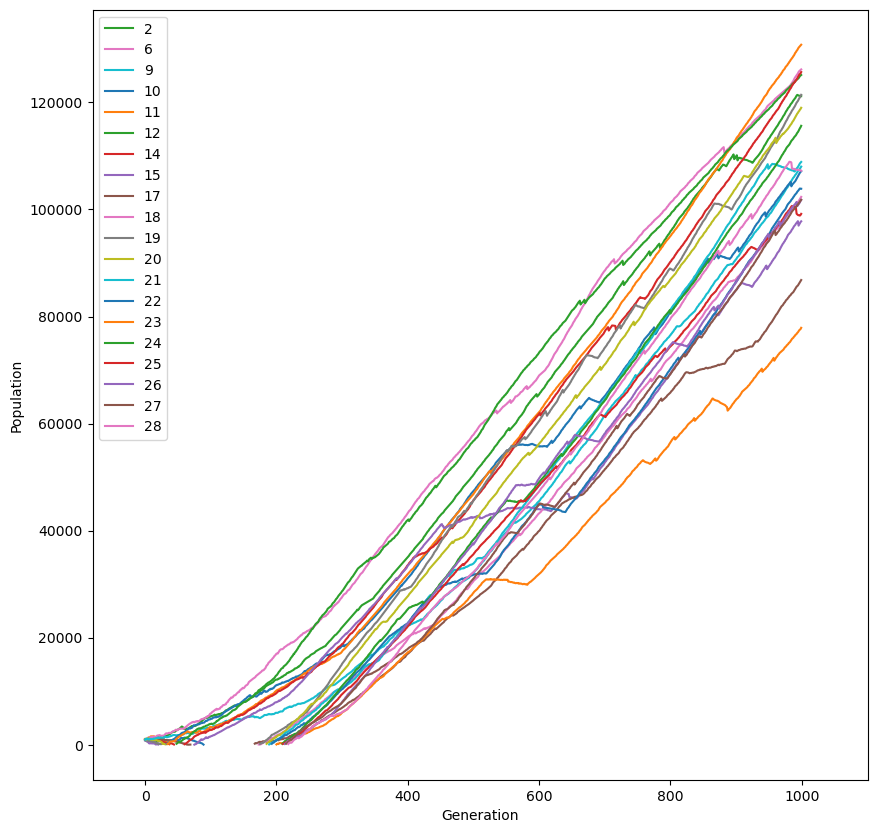

In [17]:
plt.figure(figsize=(10, 10))
for key, val in populations.items():
    
    label = key if len(val) > 10 and val[-1] > 1000 else "_nolegend_"
    
    plt.plot([t for t in range(first_generations[key], len(val) + first_generations[key])], val, label=label)
    
    
plt.xlabel('Generation')
plt.ylabel('Population')
plt.xlim((-80, 1100))
plt.legend()


We see that even though some species went extinct in the beginning (perhaps conditions in some cell were particularly bad for them), most are succeeded and became very big (here the fact that we are not punishing for big population in any way comes for effect). 

More species are not born after ~200 generation, because the gap for number of species (20 in out case) have been filled up. 

# c. Gene transfer

Okay, now we are forgetting about 2d grid and modifying original simulation to include gene transfer:

In [3]:
N = 3  # Number of elements
num_generations = 1000
num_creatures = 10
max_creatures = 20
mutation_rate = 0.01

elements = ['A', 'B', 'C']
assert len(elements) == N


molecules = [''.join(combo) for r in range(1, len(elements) + 1) for combo in combinations(elements, r)]
concentrations = {m: 0.5 for m in molecules} # Uniform concentrations in the beginning

print(f"The (2^{N}-1)={2**N - 1} molecules are: {molecules}")

The (2^3-1)=7 molecules are: ['A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC']


New functions to average coefficients:

In [4]:
def average_toxicity(father, mother):
    return {m: (father.toxicity[m] + mother.toxicity[m]) / 2 for m in father.toxicity}


def average_coefficients(father, mother):
    averaged_coeffs = []

    for i in range(3):  # 3 types of reactions
        likelihood = {}
        benefit = {}
        if i != 2:  # First and second reactions
            for m in father.coefficients[i][0]:
                likelihood[m] = (father.coefficients[i][0][m] + mother.coefficients[i][0][m]) / 2
                benefit[m] = (father.coefficients[i][1][m] + mother.coefficients[i][1][m]) / 2
        else:  # Third reaction
            for m1 in father.coefficients[i][0]:
                likelihood[m1] = {}
                benefit[m1] = {}
                for m2 in father.coefficients[i][0][m1]:
                    likelihood[m1][m2] = (father.coefficients[i][0][m1][m2] + mother.coefficients[i][0][m1][m2]) / 2
                    benefit[m1][m2] = (father.coefficients[i][1][m1][m2] + mother.coefficients[i][1][m1][m2]) / 2
        averaged_coeffs.append([likelihood, benefit])

    return averaged_coeffs

In [5]:
SCALING_FACTOR = 100 # number by which we multiply benefits and toxicity to add to our population
REACTION_STRENGTH = 0.01 # number by which concentrations of molecules increase/decrease in every reaction


class Creature:
    def __init__(self, id_num, population = 1000, first_generation = 0, father=None, mother=None):
        self.id = id_num
        self.population = population
        self.first_generation = first_generation  # Saving when the creature was created, to correctly plot it afterward
        
        
        if father is not None and mother is not None:  # Gene transfer
            self.coefficients = average_coefficients(father, mother)
            self.toxicity = average_toxicity(father, mother)
            
            return
                
        if father is not None:  # Original mutation
            self.coefficients = copy.deepcopy(father.coefficients)
            self.toxicity = copy.deepcopy(father.toxicity)
            
            # Random mutation: 
            molecule = np.random.choice(molecules)
            
            if np.random.uniform() < 1.0/4:
                self.toxicity[molecule] *= np.random.uniform(0.5, 1.5)
            else:
                i = np.random.randint(0, 2 + 1)
                j = np.random.randint(0, 1 + 1)
                
                if i != 2: # Not third reaction
                    while len(molecule) == 1:  # First and second reactions could not happen with molecule of one letter
                        molecule = np.random.choice(molecules)
                    self.coefficients[i][j][molecule] *= np.random.uniform(0.5, 1.5)
                    
                else:
                    molecule2 = np.random.choice(molecules)
                    while not check_reaction_3(molecule, molecule2):
                        molecule2 = np.random.choice(molecules)
                    self.coefficients[i][j][molecule][molecule2] *= np.random.uniform(0.5, 1.5)
                    
            return
        
        # Initializing coefficients
        
        self.toxicity = {m: np.random.uniform() for m in molecules}  # Toxicity of every molecule
        
        # First type of reactions, cannot happen for 1 letter molecules
        reaction_1_likelihood = {m: np.random.uniform() for m in molecules if len(m) > 1}
        reaction_1_benefit = {m: np.random.uniform(-1, 1) for m in molecules if len(m) > 1} # Benefit / penalty
        
        # Second type of reactions, cannot happen for 1 letter molecules
        reaction_2_likelihood = {m: np.random.uniform() for m in molecules}
        reaction_2_benefit = {m: np.random.uniform(-1, 1) for m in molecules} # Benefit / penalty
        
        # Third type of reactions
        reaction_3_likelihood = {}
        reaction_3_benefit = {}
        # So we can access likelihood of the reaction A + BC -> ABC as reaction_3_likelihood["A"]["BC"] 
        # The component first in the molecules list should always go first, trying to access reaction_3_likelihood["BC"]["A"] will result in error
        
        for m1 in molecules:
            reaction_3_likelihood[m1] = {}
            reaction_3_benefit[m1] = {}
            
            for m2 in molecules:
                if check_reaction_3(m1, m2):
                    reaction_3_likelihood[m1][m2] = np.random.uniform()
                    reaction_3_benefit[m1][m2] = np.random.uniform(-1, 1)
                
        self.coefficients = [[reaction_1_likelihood, reaction_1_benefit], 
                             [reaction_2_likelihood, reaction_2_benefit], 
                             [reaction_3_likelihood, reaction_3_benefit]] # List of all coefficients 


    def __lt__(self, other):  # For sorting
        return self.population < other.population

    def reaction_1(self, molecule):
        reaction_chance = self.coefficients[0][0][molecule] * concentrations[molecule]
        
        if np.random.uniform() < reaction_chance:
            for element in molecule:
                concentrations[element] -= REACTION_STRENGTH
                
            concentrations[molecule] += REACTION_STRENGTH
            
            self.population += int(self.coefficients[0][1][molecule] * SCALING_FACTOR)
            self.population -= int(self.toxicity[molecule] * REACTION_STRENGTH * SCALING_FACTOR)
            
            
    def reaction_2(self, molecule):
        reaction_chance = self.coefficients[1][0][molecule] * concentrations[molecule]
        
        if np.random.uniform() < reaction_chance:
            for element in molecule:
                concentrations[element] += REACTION_STRENGTH
                self.population -= int(self.toxicity[element] * REACTION_STRENGTH * SCALING_FACTOR)

                
            concentrations[molecule] -= REACTION_STRENGTH
            
            self.population += int(self.coefficients[1][1][molecule] * SCALING_FACTOR) 
            
            
    def reaction_3(self, m1, m2):
        reaction_chance = self.coefficients[2][0][m1][m2] * concentrations[m1] * concentrations[m2]
        
        if np.random.uniform() < reaction_chance:
            merged = ''.join(sorted(set(m1 + m2)))
            leftovers = ''.join(sorted(set(m1) & set(m2)))
            
            concentrations[m1] -= REACTION_STRENGTH
            concentrations[m2] -= REACTION_STRENGTH
            
            concentrations[merged] += REACTION_STRENGTH
            
            self.population += int(self.coefficients[2][1][m1][m2] * SCALING_FACTOR)
            self.population -= int(self.toxicity[merged] * REACTION_STRENGTH * SCALING_FACTOR)
            
            if leftovers != "":
                concentrations[leftovers] += REACTION_STRENGTH
                self.population -= int(self.toxicity[leftovers] * REACTION_STRENGTH * SCALING_FACTOR)
        

    def perform_reactions(self):  # Main function to perform all reactions on every step
        
        for molecule in molecules:
            if len(molecule) > 1:
                self.reaction_1(molecule)
                self.reaction_2(molecule)
            
            for molecule2 in molecules:
                if check_reaction_3(molecule, molecule2):
                    self.reaction_3(molecule, molecule2)
            

In [6]:
# Main logic
creatures = [Creature(id_num=i) for i in range(num_creatures)]  # Creatures with increasing ids
current_id = len(creatures)

populations = {}
first_generations = {creature.id: 0 for creature in creatures}

# Simulation loop
for generation in tqdm(range(num_generations)):
    # Each creature performs its reactions
    for creature in creatures:
        creature.perform_reactions()

        # Mutation
        if np.random.uniform() < mutation_rate:
            
            if np.random.uniform() < 0.5: # Original mutation
                mutated_population = int(creature.population * 0.01)
                creatures.append(Creature(id_num=current_id, population=mutated_population, first_generation=generation, father=creature))
                
                creature.population -= mutated_population
                
            else:  # Gene transfer
                parent2 = np.random.choice(creatures)
                new_population = int((creature.population + parent2.population) * 0.01)  # Same coefficient (0.01) as for original mutation
                creatures.append(Creature(id_num=current_id, population=new_population, first_generation=generation, father=creature, mother=parent2))
                creature.population -= int(creature.population * 0.005)
                parent2.population -= int(parent2.population * 0.005)

            
            first_generations[current_id] = generation
            
            current_id += 1
        
    # Remove creatures close to extinction
    creatures = [creature for creature in creatures if creature.population > 1]
    
    if len(creatures) > max_creatures:
        creatures = sorted(creatures)
        creatures = creatures[-max_creatures:]
    
    if generation % 1 == 0:  # Collecting data every generation, can be changed
        for creature in creatures:
            if creature.id in populations.keys():
                populations[creature.id].append(creature.population)
            else:
                populations[creature.id] = [creature.population]
                
        if generation % 100 == 0:
            print(f"Generation {generation}: Total Population: {sum([creature.population for creature in creatures])}")

 39%|███▉      | 394/1000 [00:00<00:00, 1800.68it/s]

Generation 0: Total Population: 9771
Generation 100: Total Population: 39692
Generation 200: Total Population: 39534
Generation 300: Total Population: 39183
Generation 400: Total Population: 38892


 75%|███████▌  | 751/1000 [00:00<00:00, 1718.69it/s]

Generation 500: Total Population: 38537
Generation 600: Total Population: 38251
Generation 700: Total Population: 37728
Generation 800: Total Population: 37224
Generation 900: Total Population: 36976


100%|██████████| 1000/1000 [00:00<00:00, 1736.16it/s]


In [7]:
print(f"{len([creature.population for creature in creatures if creature.population > 1000])} species finished with the population above 1000")

11 species finished with the population above 1000


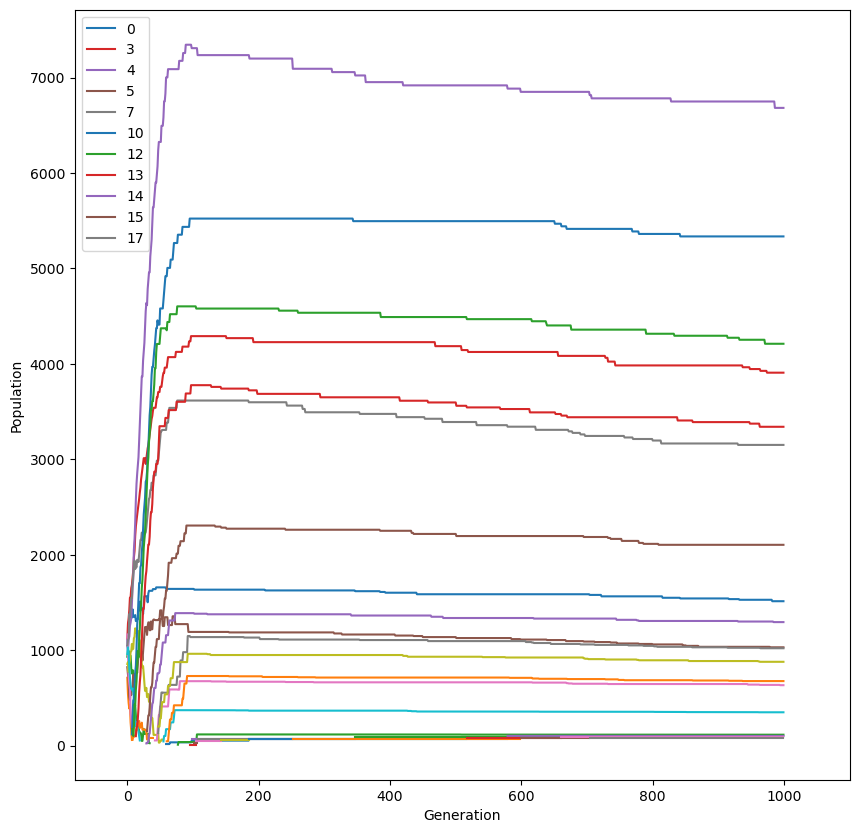

In [9]:
plt.figure(figsize=(10, 10))
for key, val in populations.items():
    
    label = key if len(val) > 10 and val[-1] > 1000 else "_nolegend_"
    
    plt.plot([t for t in range(first_generations[key], len(val) + first_generations[key])], val, label=label)
    
    
plt.xlabel('Generation')
plt.ylabel('Population')
plt.xlim((-80, 1100))
plt.legend()

I would say that the behaviour did not change much in comparison to a). We can observe same initial rise and then stable plato. One thing we can note is that there are a slightly more species that finished with the population higher than a 1000.
 
I used the same seed for this, so this might mean that this "averaging" of coefficients slightly improved probability to "thrive".